# A simple experimental scenario

[Simon Dobson](mailto:simon.dobson@st-andrews.ac.uk) <br>
School of Computer Science, University of St Andrews, Scotland UK

## Introduction

Let's consider a simple scenario of sensing: a grid of sample points (of rain, for the sake of argument), equally-spaced within a rectangular area. We'll then interpolate these samples at a finer resolution to show how the samples are used to drive the interpolation function, represented as a tensor. We'll then explore what happewns when the samples are degraded by randomly removing some proportion of them, and see whether we can use the tensor to derive some insight into the effects of such degradation, and of the effects of errors.

In [1]:
from os.path import exists
from copy import deepcopy
import numpy
from geopandas import GeoDataFrame, GeoSeries, read_file

from sensor_placement import *
from sensor_placement.data import *
from sensor_placement.matplotlib import *

import shapely
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint, shape
from shapely.ops import cascaded_union, nearest_points

#import logging
#logging.basicConfig(level=logging.DEBUG)

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize, LogNorm, TwoSlopeNorm, ListedColormap, to_rgba
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
rng = numpy.random.default_rng()

## The full-resolution sample grid

For our scenario, we'll use a regular grid of samples five on a side, and an interpolation grid 100 on a side, sitting within a unit square.

In [3]:
samplesPer = 5
pointsPer = 100

nSamples = samplesPer * samplesPer
nPoints = pointsPer * pointsPer

In [4]:
dx = 1 / (samplesPer + 1)
points = []
for y in range(samplesPer):
    for x in range(samplesPer):
        points.append(Point(((x + 1) * dx, (samplesPer - y) * dx)))

df_samples = GeoDataFrame(points, columns=['geometry'])

In [5]:
dx = 1 / (pointsPer + 1)
xs = [ (x + 1) * dx for x in range(pointsPer)]
ys = [ (pointsPer - y) * dx for y in range(pointsPer)]

In [6]:
boundary = Polygon([Point(0.0, 0.0),
                    Point(0.0, 1.0),
                    Point(1.0, 1.0),
                    Point(1.0, 0.0)])

From this we can create a natural nearewst-neighbour interpolation tensor. 

In [7]:
if exists('datasets/tensor_fullresolution.nc'):
    tensor_fullresolution = NNNI.load('datasets/tensor_fullresolution.nc')
else:
    tensor_fullresolution = NNNI(df_samples, boundary, xs, ys)
    tensor_fullresolution.save('datasets/tensor_fullresolution.nc')

The scenario is shown below, with crosses indicating sample points.

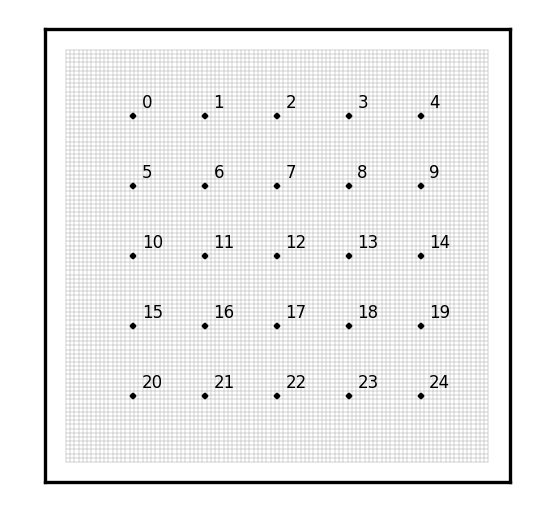

In [8]:
fig = plt.figure(figsize=(2, 2))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])

for y in ys:
    ax.plot(xs, [y] * len(xs), color='0.6', linewidth=0.1)
for x in ys:
    ax.plot([x] * len(xs), ys, color='0.6', linewidth=0.1)
    
drawSampleLabels(tensor_fullresolution, ax=ax, include_sample_indices=False)

_ = plt.show()

## Ground truth

We now need an array of samples at the full sampling resolution. We construct this by assigning values to the sample points, both above and below a baseline value.

In [9]:
samples = numpy.full((nSamples,), fill_value=5)

samples[0] = 20
samples[2] = 15
samples[3] = 12
samples[4] = 15
samples[5] = 10
samples[1] = 10
samples[10] = 8
samples[13] = 35
samples[15] = 16
samples[16] = 5
samples[20] = 22
samples[21] = 25
samples[24] = 1

We can show these samples as colour blobs, without any interpolation.

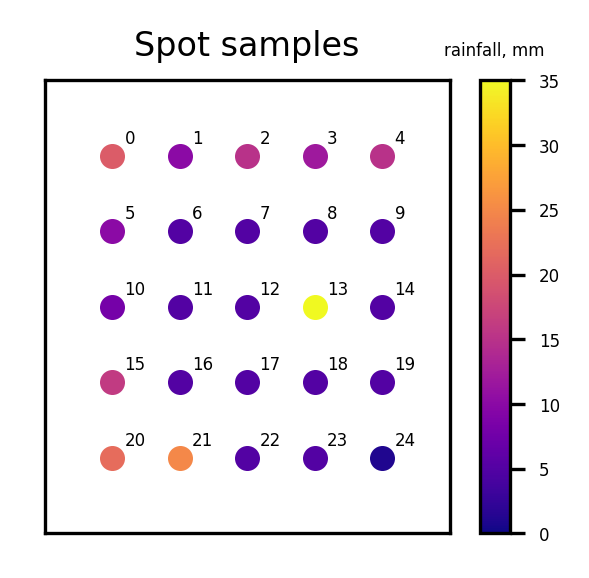

In [10]:
fig = plt.figure(figsize=(2, 2))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])

drawSamples(tensor_fullresolution, samples, ax=ax, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')

ax.set_title('Spot samples', fontsize=8)

_ = plt.show()

Interpolating these samples involves applying the tensor to the vector of samples, yielding a grid of interpolated values. We also include the Voronoi cell boundaries.

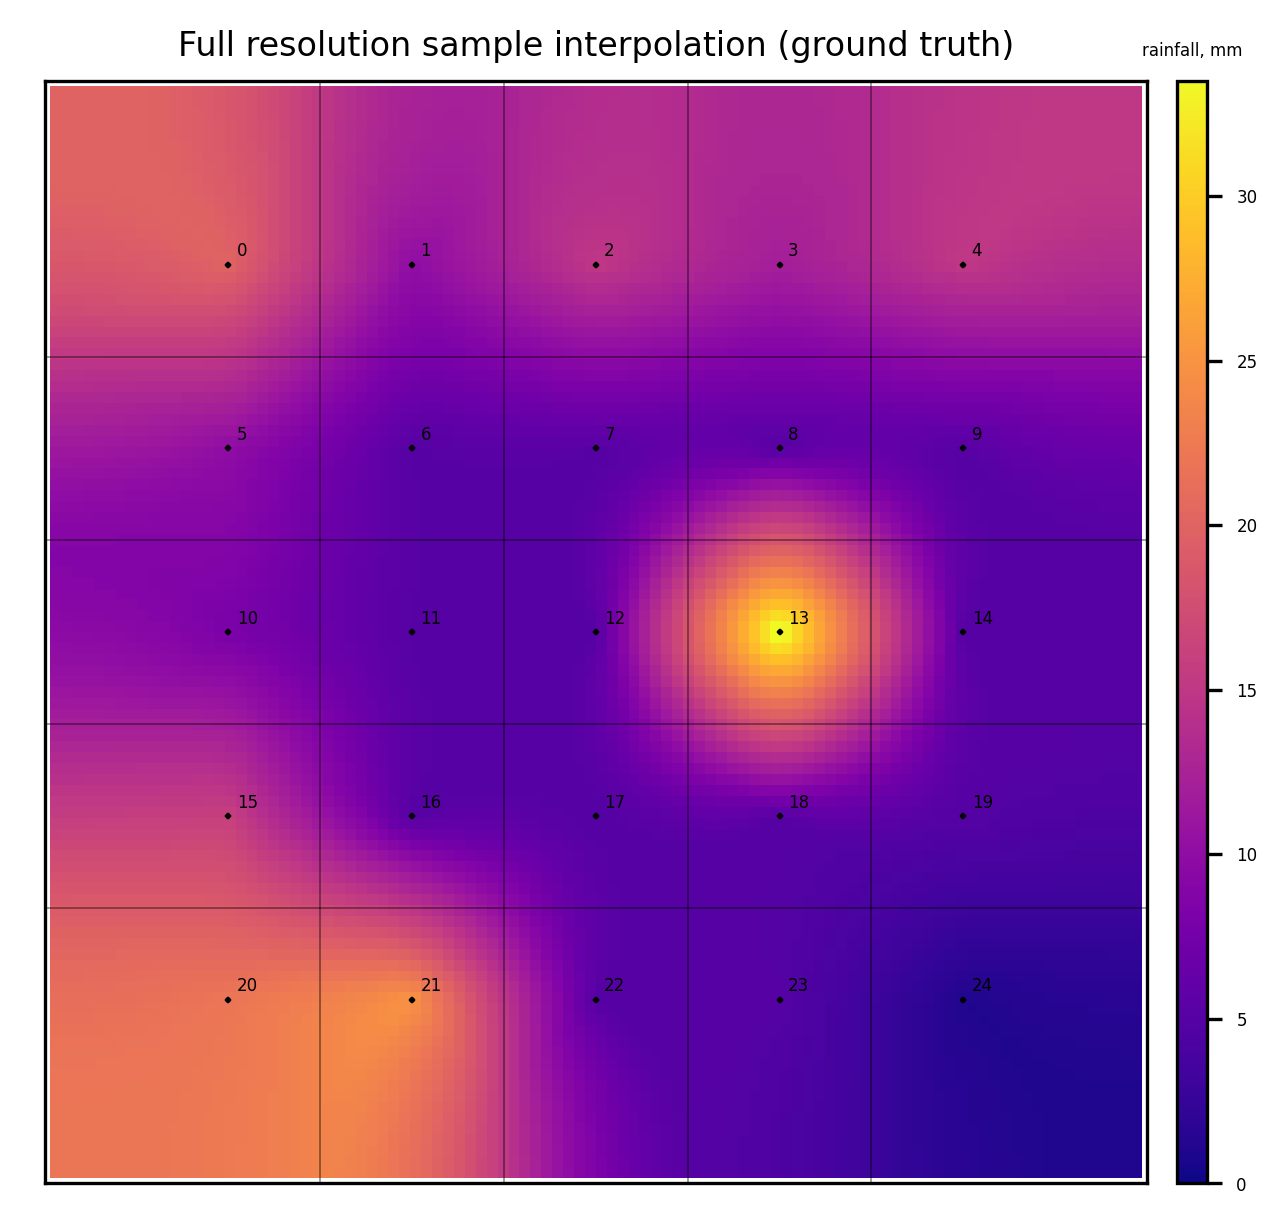

In [11]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

drawInterpolation(tensor_fullresolution, samples, ax=ax, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')
drawVoronoiCells(tensor_fullresolution, ax=ax)
drawSampleLabels(tensor_fullresolution, ax=ax, include_sample_indices=False)

ax.set_title('Full resolution sample interpolation (ground truth)', fontsize=8)

_ = plt.show()

## Remove 40% of samples

Now remove 40% of the sample points at random, leaving 60% for interpolation. The removal process removes samples from the sample vector, and removes the corresponding samples from the tensor.

In [12]:
if exists('datasets/tensor_60.nc'):
    tensor_60 = NNNI.load('datasets/tensor_60.nc')
    retain_60 = list(tensor_60._samples.index)
    samples_60 = samples[retain_60]    
else:
    retain_60 = sorted(numpy.random.choice(range(len(samples)), int(len(samples) * 0.6), replace=False))
    remove_60 = sorted(list(set(range(len(samples))) - set(retain_60)))

    samples_60 = samples[retain_60]

    tensor_60 = deepcopy(tensor_fullresolution)
    for i in remove_60:
        tensor_60.removeSample(i)
        
    tensor_60.save('datasets/tensor_60.nc')

Plotting the results from the degraded sample shows a sigfnificantly different pattern, as one would expect. (We label the sample points with their index in the sample vector and their sample identifier (from the full-rewsolution vecotr) in brackets, together with the new Voronoi cells.)

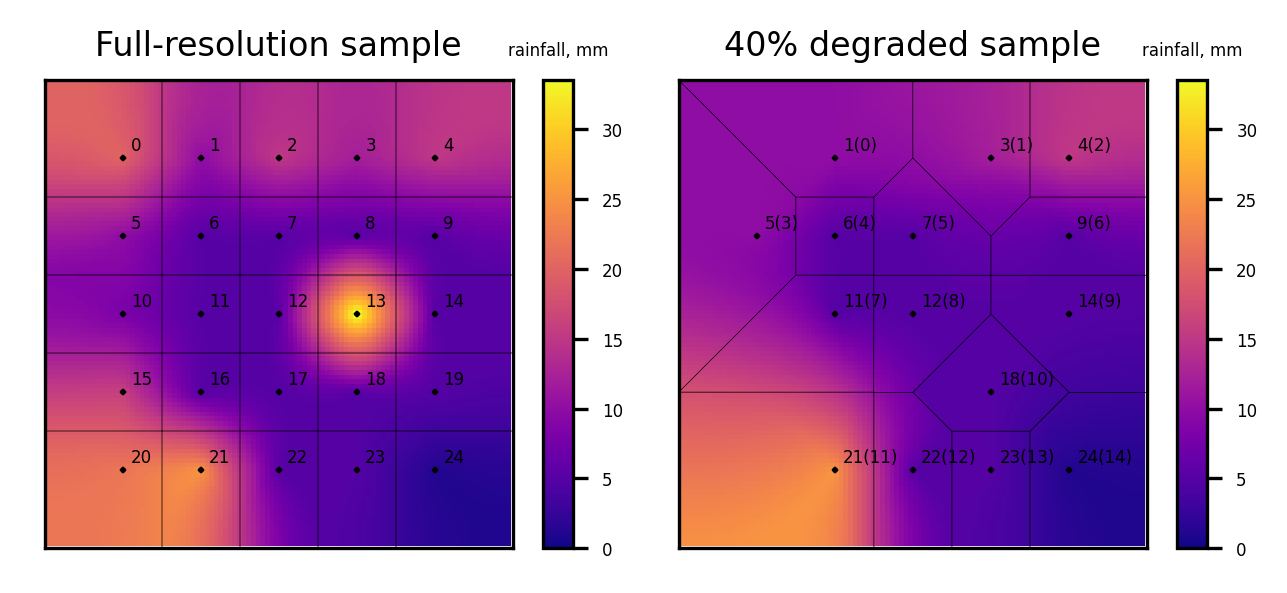

In [13]:
fig = plt.figure(figsize=(5,5))

# full-resolution
ax1 = plt.subplot(1, 2, 1, xticks=[], yticks=[])
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
_, _, norm = drawInterpolation(tensor_fullresolution, samples, ax=ax1, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')
drawVoronoiCells(tensor_fullresolution, ax=ax1)
drawSampleLabels(tensor_fullresolution, ax=ax1, include_sample_indices=False)
ax1.set_title('Full-resolution sample', fontsize=8)
        
# degraded resolution
ax2 = plt.subplot(1, 2, 2, xticks=[], yticks=[])
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])
drawInterpolation(tensor_60, samples_60, ax=ax2, norm=norm, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')
drawVoronoiCells(tensor_60, ax=ax2)
drawSampleLabels(tensor_60, ax=ax2)
ax2.set_title('40% degraded sample', fontsize=8)

_ = plt.show()

We can plot the difference in temperature between these two interpolations, with yellows indicating that the full-resolution sample is hotter and blues that the degraded resolution is hotter. 

In [14]:
g_diff = tensor_fullresolution.apply(samples) - tensor_60.apply(samples_60)

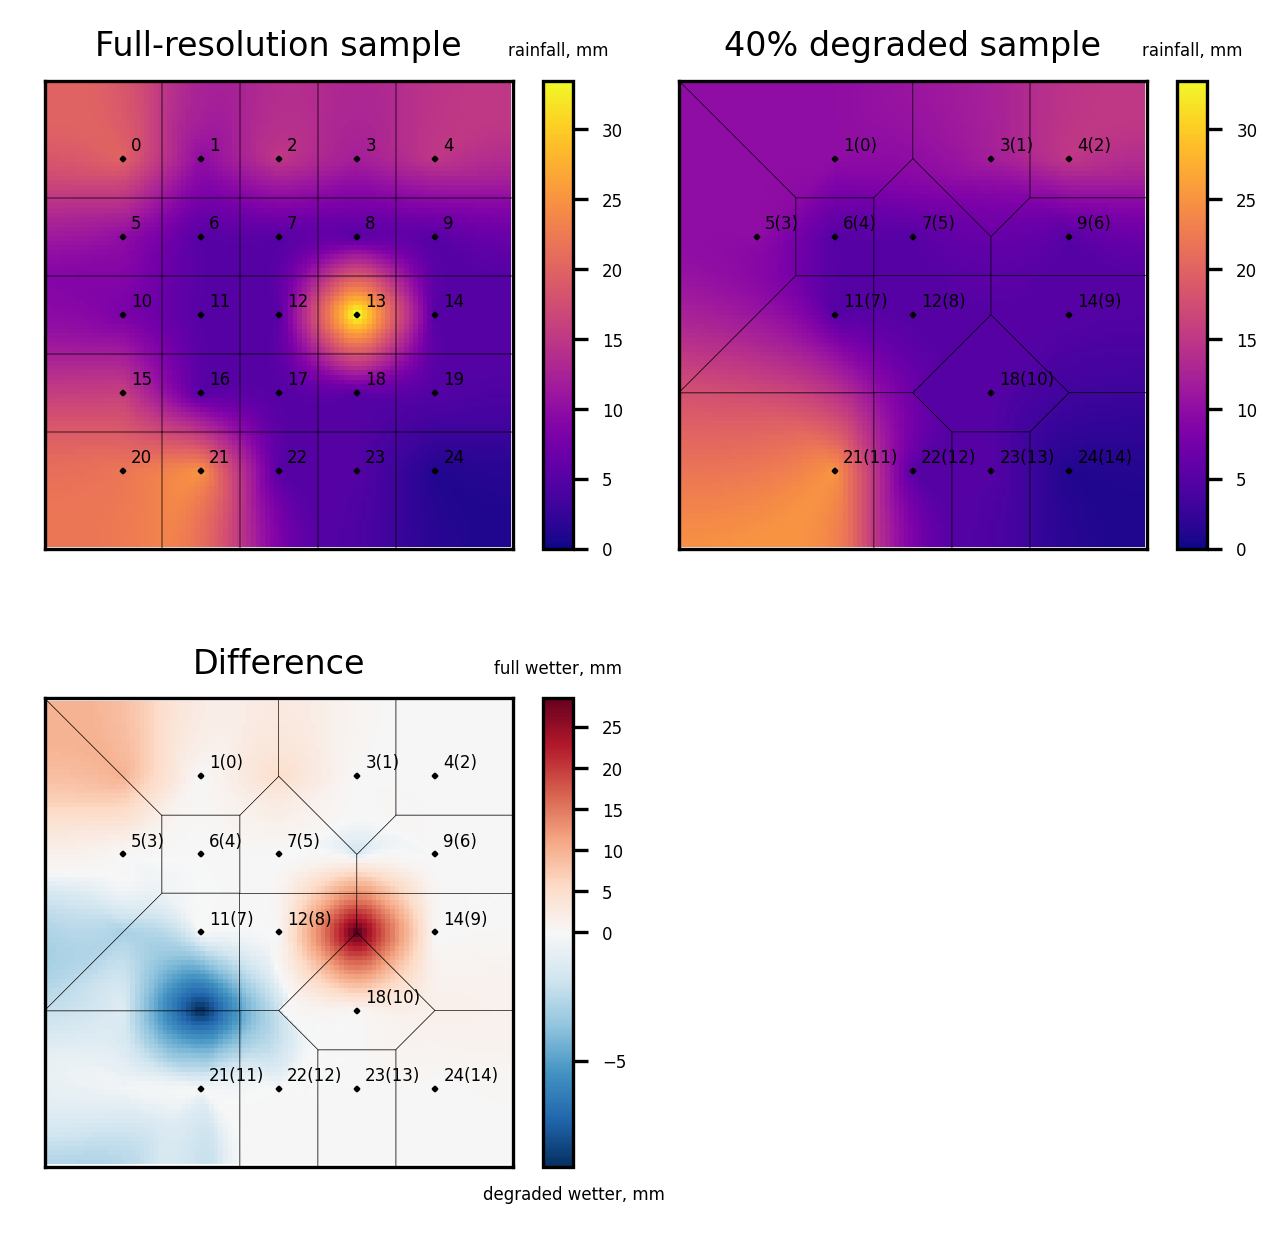

In [15]:
fig = plt.figure(figsize=(5,5))

# full-resolution
ax1 = plt.subplot(2, 2, 1, xticks=[], yticks=[])
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
_, _, norm = drawInterpolation(tensor_fullresolution, samples, ax=ax1, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')
drawVoronoiCells(tensor_fullresolution, ax=ax1)
drawSampleLabels(tensor_fullresolution, ax=ax1, include_sample_indices=False)
ax1.set_title('Full-resolution sample', fontsize=8)

# degraded resolution
ax2 = plt.subplot(2, 2, 2, xticks=[], yticks=[])
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])
drawInterpolation(tensor_60, samples_60, ax=ax2, norm=norm, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')
drawVoronoiCells(tensor_60, ax=ax2)
drawSampleLabels(tensor_60, ax=ax2)
ax2.set_title('40% degraded sample', fontsize=8)

# difference
ax3 = plt.subplot(2, 2, 3, xticks=[], yticks=[])
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.0])
norm = TwoSlopeNorm(vcenter=0, vmin=g_diff.min(), vmax=g_diff.max())
_, cax, _ = drawGrid(g_diff, xs, ys, ax=ax3, norm=norm, cmap=cm.get_cmap('RdBu_r'), cmap_title='full wetter, mm')
drawVoronoiCells(tensor_60, ax=ax3)
drawSampleLabels(tensor_60, ax=ax3)
ax3.set_title('Difference', fontsize=8)
cax.annotate('degraded wetter, mm', xy=(0.5, 0.0), xycoords='axes points', xytext=(-15, -8), textcoords='offset points', fontsize=4)

_ = plt.show()

## Error vectors

Each interpolated point gets its value by weighting the values of a set of sample points -- the exact points and weights being defined by the interpolation algorithm. These weights can be treated like a vector located at the intrerpolation point and pointing towards the sample point, with the weight giving the vector's magnitude.

We can start by plotting the dominant vector, the single vecxtor at each chosen interpolation poin t with the largest magnitude (*i.e.*, the sample with the largest weight). 

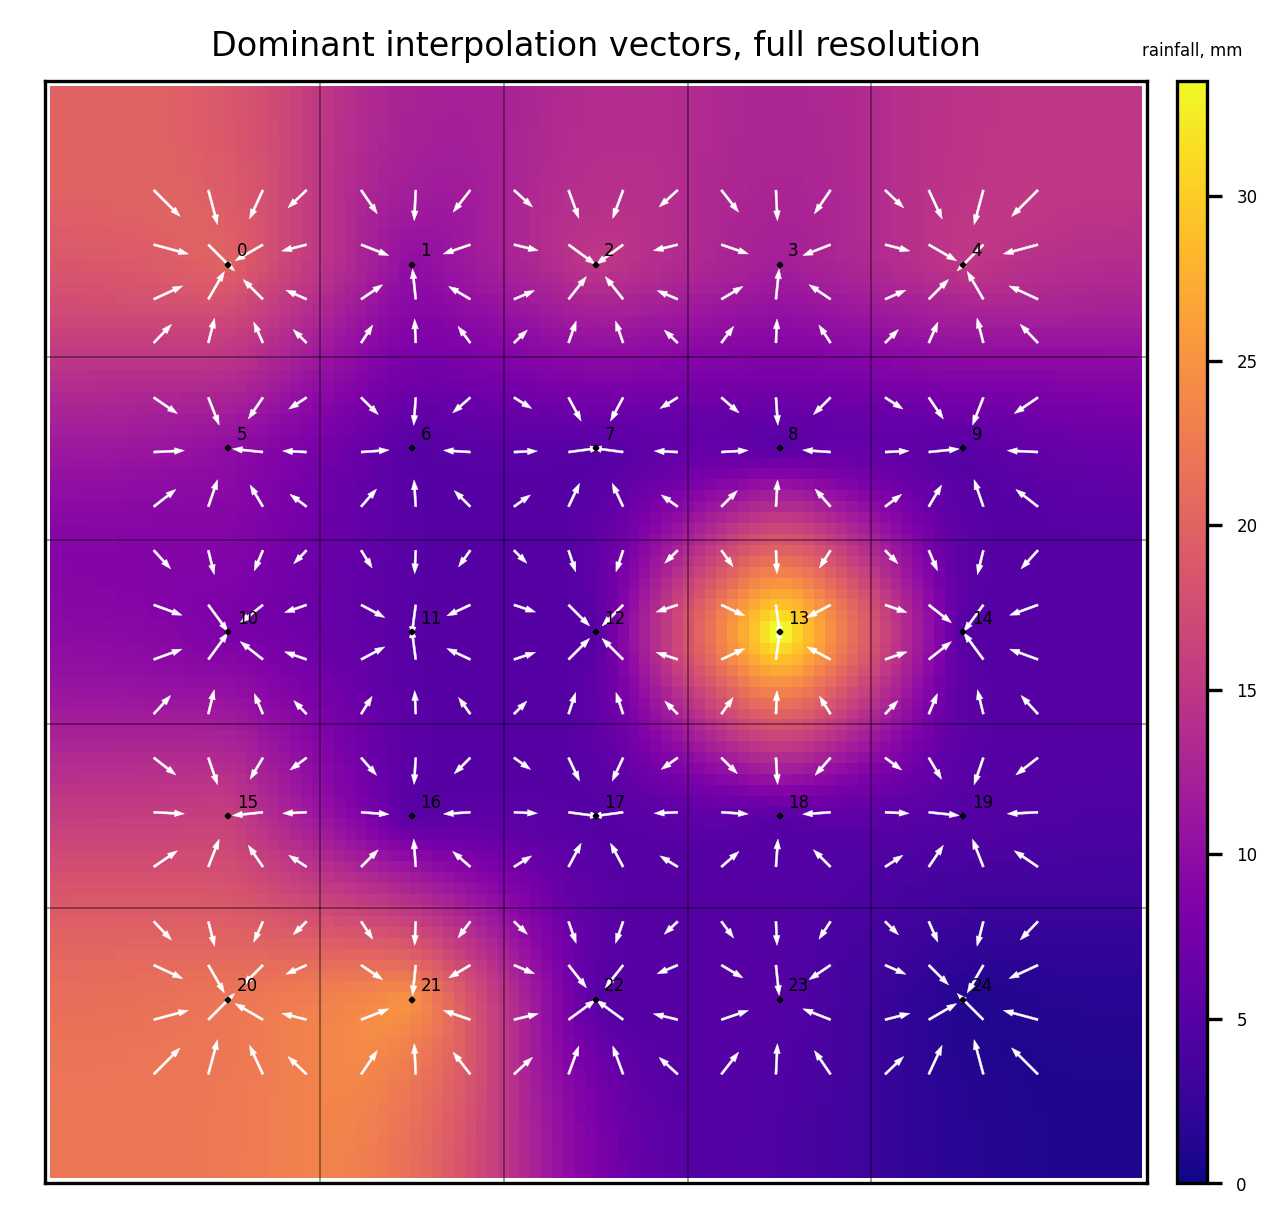

In [18]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

_, _, norm = drawInterpolation(tensor_fullresolution, samples, ax=ax, cmap=cm.get_cmap('plasma'), cmap_title='rainfall, mm')

for x in numpy.linspace(0.1, 0.9, 18):
    for y in numpy.linspace(0.1, 0.9, 18):
        #drawWeightVectors(tensor_fullresolution, nearestPointTo(Point(x, y), tensor_fullresolution),
        #                  ax=ax, color='g', radius=0.025, cutoff=0.01)
        drawDominantWeightVector(tensor_fullresolution, nearestPointTo(Point(x, y), tensor_fullresolution),
                                 ax=ax, color='w', radius=0.025, cutoff=0.01, overwrite=False)

drawVoronoiCells(tensor_fullresolution, ax=ax)
drawSampleLabels(tensor_fullresolution, ax=ax, include_sample_indices=False)

ax.set_title('Dominant interpolation vectors, full resolution', fontsize=8)

_ = plt.show()

With the interpolation from the degraded sample, in instead plot all the weight vectors, cutting-out those with very small weights. This still leaves several significant factors in interpolating many sample points.

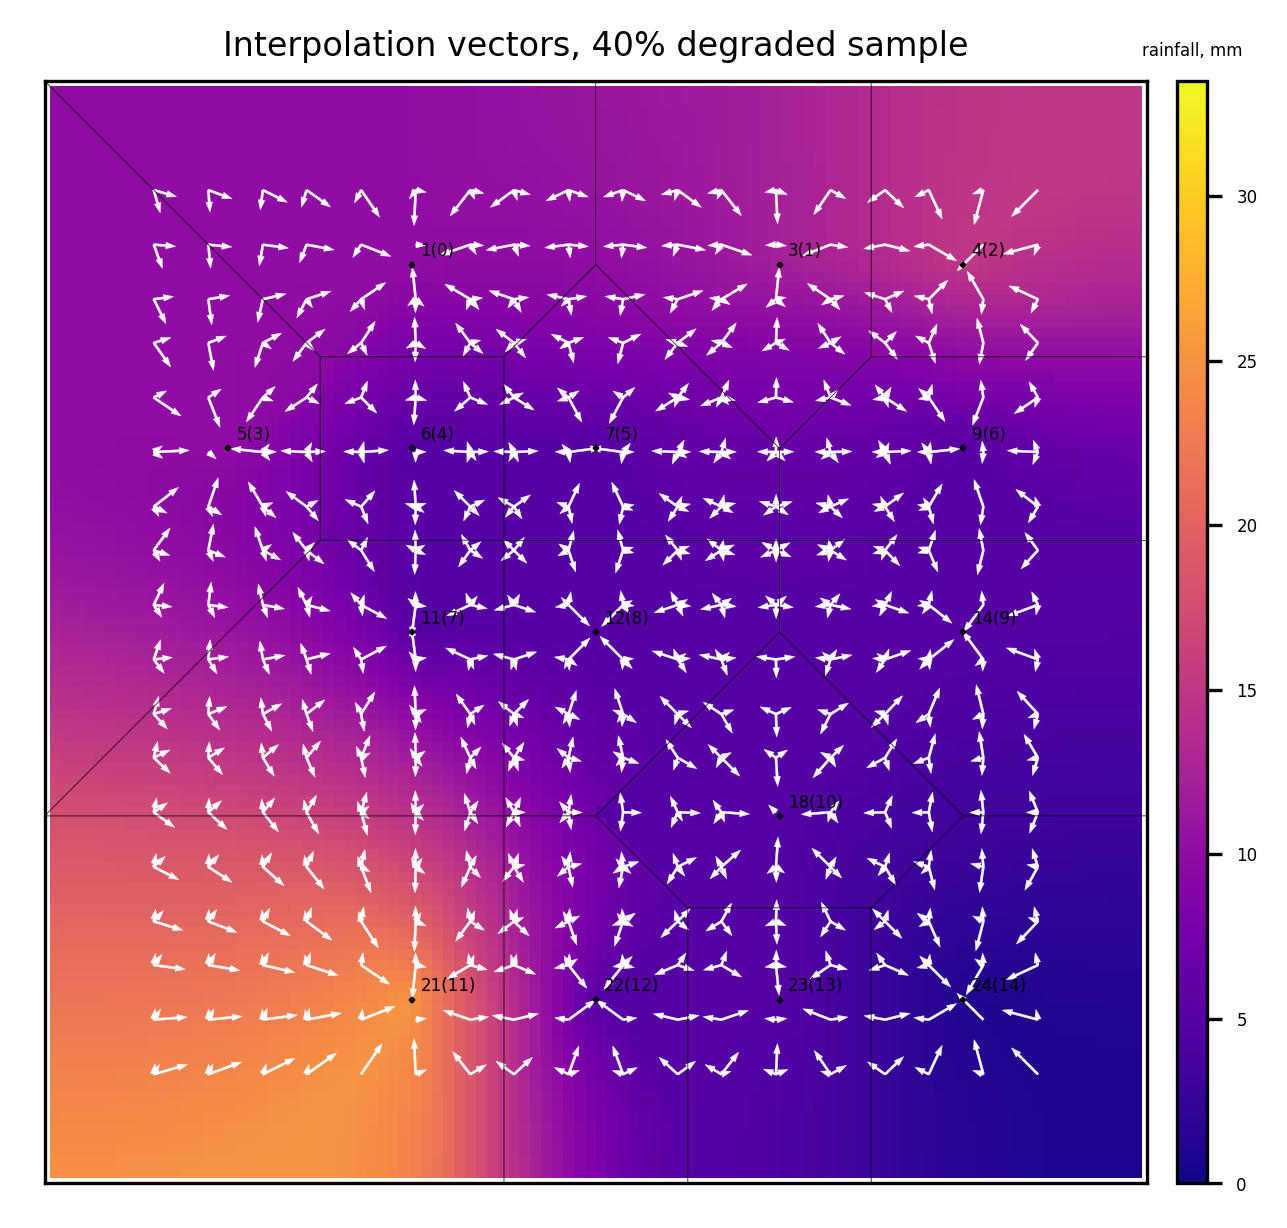

In [19]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1, xticks=[], yticks=[])
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

drawInterpolation(tensor_60, samples_60, ax=ax, cmap=cm.get_cmap('plasma'), norm=norm, cmap_title='rainfall, mm')

for x in numpy.linspace(0.1, 0.9, 18):
    for y in numpy.linspace(0.1, 0.9, 18):
        drawWeightVectors(tensor_60, nearestPointTo(Point(x, y), tensor_60),
                          ax=ax, color='w', radius=0.025, cutoff=0.01, overwrite=False)

drawVoronoiCells(tensor_60, ax=ax)
drawSampleLabels(tensor_60, ax=ax)

ax.set_title('Interpolation vectors, 40% degraded sample', fontsize=8)

_ = plt.show()